In [150]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [151]:
Image_size=32
Batch_size=32
Channel=3
Epochs=50

In [152]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("Tomato",seed=123,shuffle=True,image_size=(Image_size,Image_size),batch_size=Batch_size)

Found 16011 files belonging to 10 classes.


In [153]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [154]:
len(dataset)

501

In [155]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 32, 32, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]


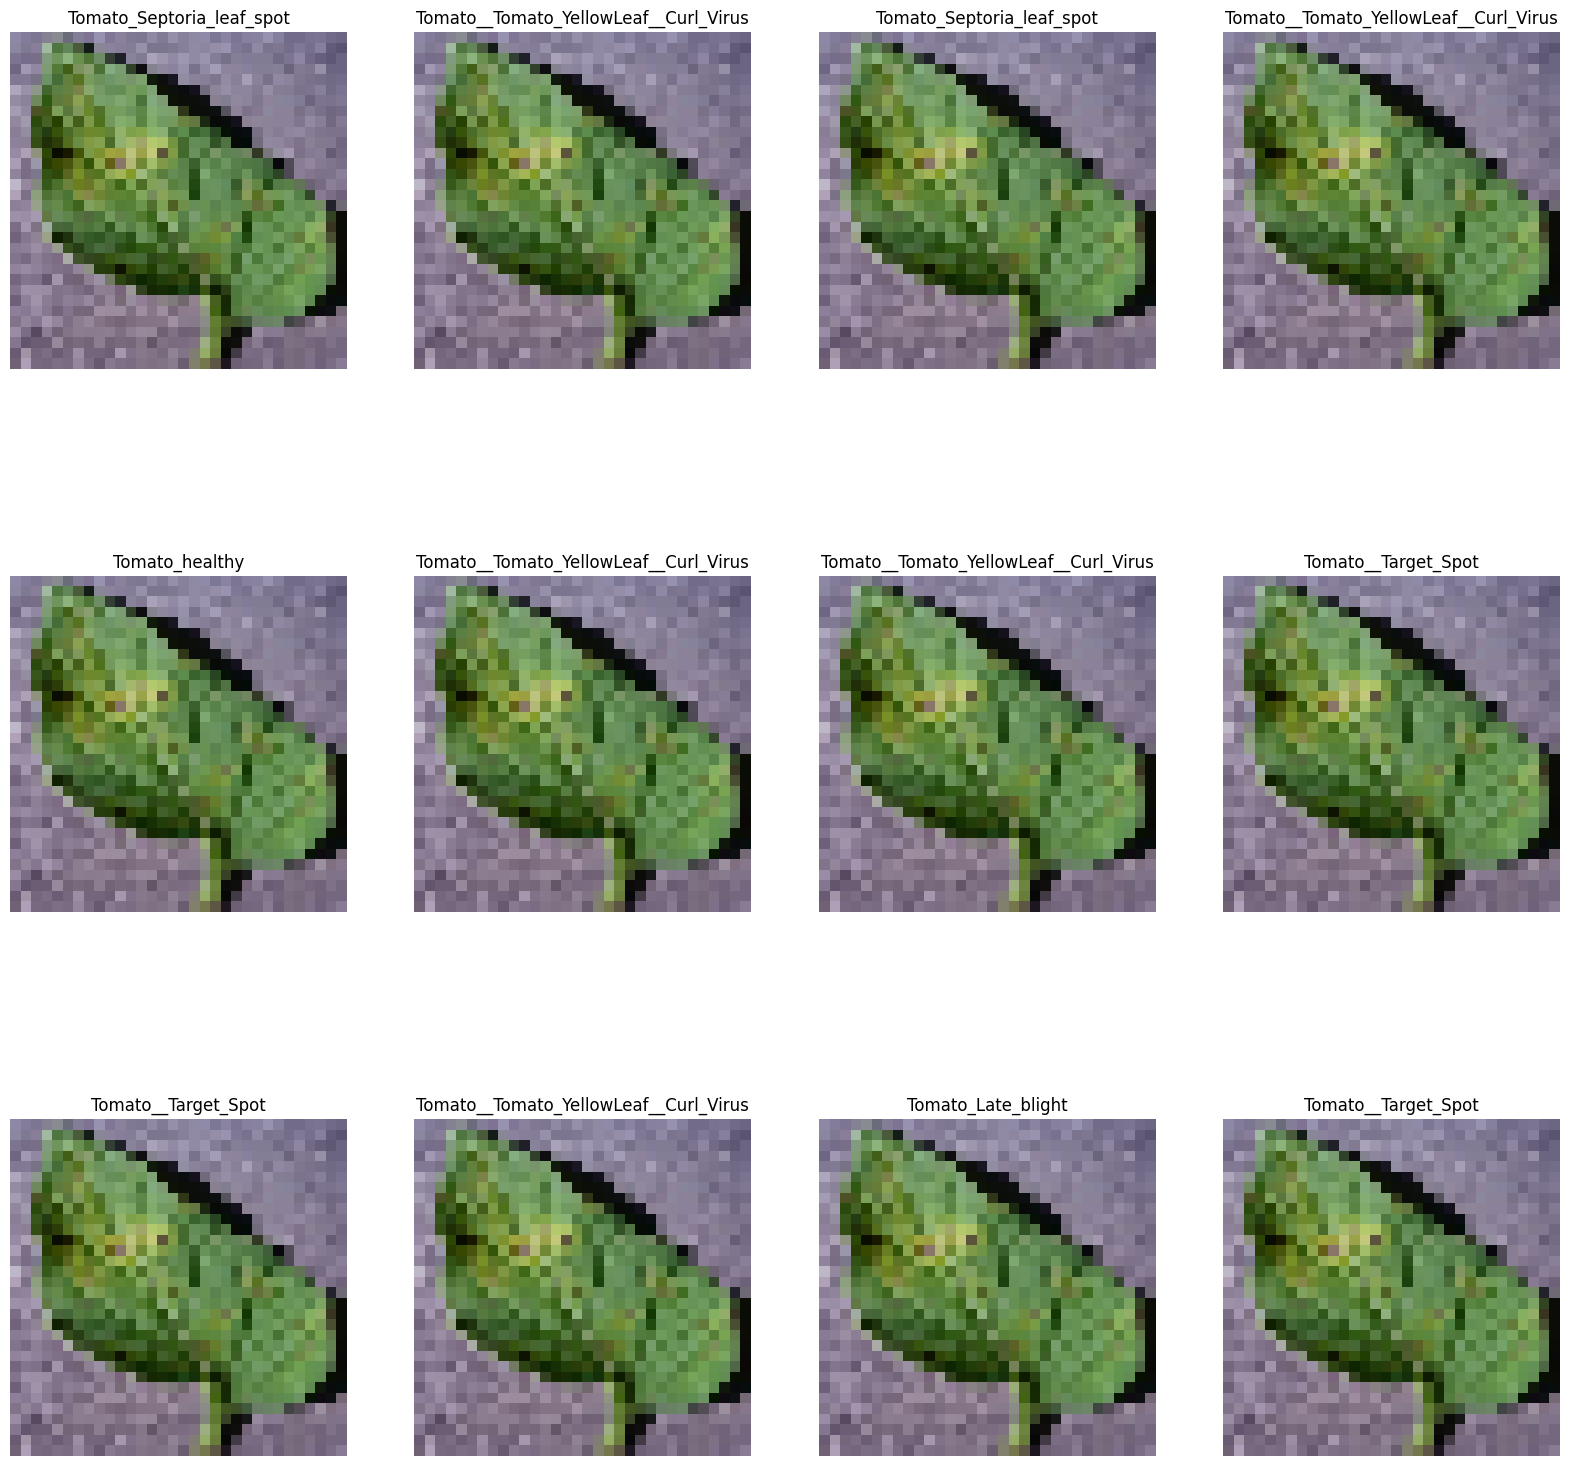

In [156]:
plt.figure(figsize=(20,20))
for image_batch ,label_batch in dataset.take(1):
    for i in range (12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [157]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [158]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [159]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [160]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [161]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(Image_size,Image_size),
    layers.Rescaling(1.0/255)
])

In [162]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),

    layers.RandomRotation(0.2),
])

In [173]:
input_shape = (Image_size, Image_size, Channel)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Removed one pooling layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [174]:
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)      │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_25 (Sequential)      │ (32, 32, 32, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (32, 32, 32, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (32, 16, 16, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (32, 16, 16, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (32, 8, 8, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (32, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (32, 4, 4, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (32, 2048)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (32, 64)               │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,890 (1.14 MB)

 Trainable params: 298,890 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [176]:
history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.2779 - loss: 1.9707 - val_accuracy: 0.5519 - val_loss: 1.2520
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6244 - loss: 1.0956 - val_accuracy: 0.7088 - val_loss: 0.8076
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7433 - loss: 0.7249 - val_accuracy: 0.7531 - val_loss: 0.6693
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7850 - loss: 0.6042 - val_accuracy: 0.7119 - val_loss: 0.9109
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.8277 - loss: 0.4860 - val_accuracy: 0.8450 - val_loss: 0.4693
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 54s 135ms/step - accuracy: 0.8450 - loss: 0.4280 - val_accuracy: 0.7706 - val_loss: 0.6528
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 146ms/step - accuracy: 0.8591 - loss: 0.4004 - val_accuracy: 0.8144 - val_loss: 0.5761
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.8709 - loss: 0.3640

In [177]:
scores=model.evaluate(test_ds)
scores

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9384 - loss: 0.1934


[0.19239406287670135, 0.938725471496582]

In [178]:
history

In [179]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [180]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [181]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

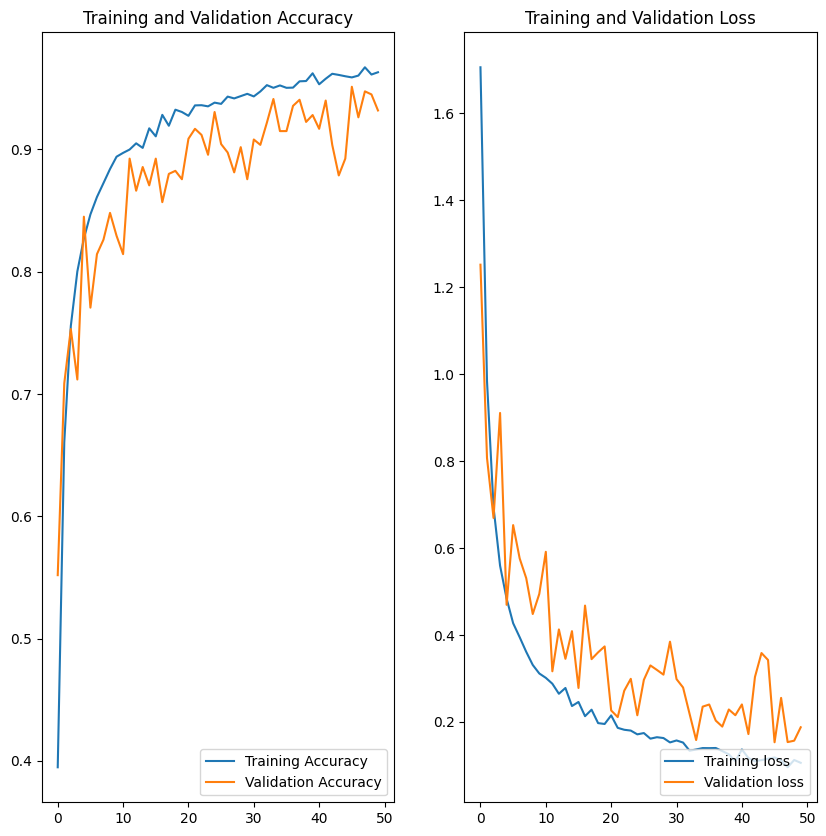

In [182]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label='Training Accuracy')
plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(Epochs),loss,label='Training loss')
plt.plot(range(Epochs),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

Image to predict
actual label Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
predicted label: Tomato_healthy
Image to predict
actual label Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus
Image to predict
actual label Tomato_Septoria_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
predicted label: Tomato_Septoria_leaf_spot
Image to predict
actual label Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus
Image to predict
actual label Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
predicted label: Tomato_Late_blight
Image to predict
actual label Tomato_Septoria_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
predicted label: Tomato_Septoria_leaf_spot
Image to predict
actual label Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus
Imag

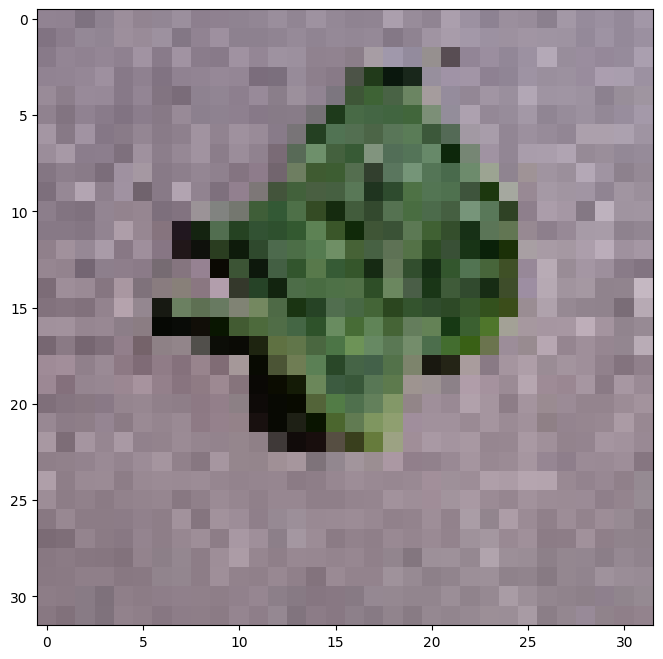

In [183]:
plt.figure(figsize=(8,8))
for image_batch ,label_batch in test_ds.take(10):
    first_image=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()
    print('Image to predict')
    plt.imshow(first_image)
    print("actual label",class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])
        

In [184]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


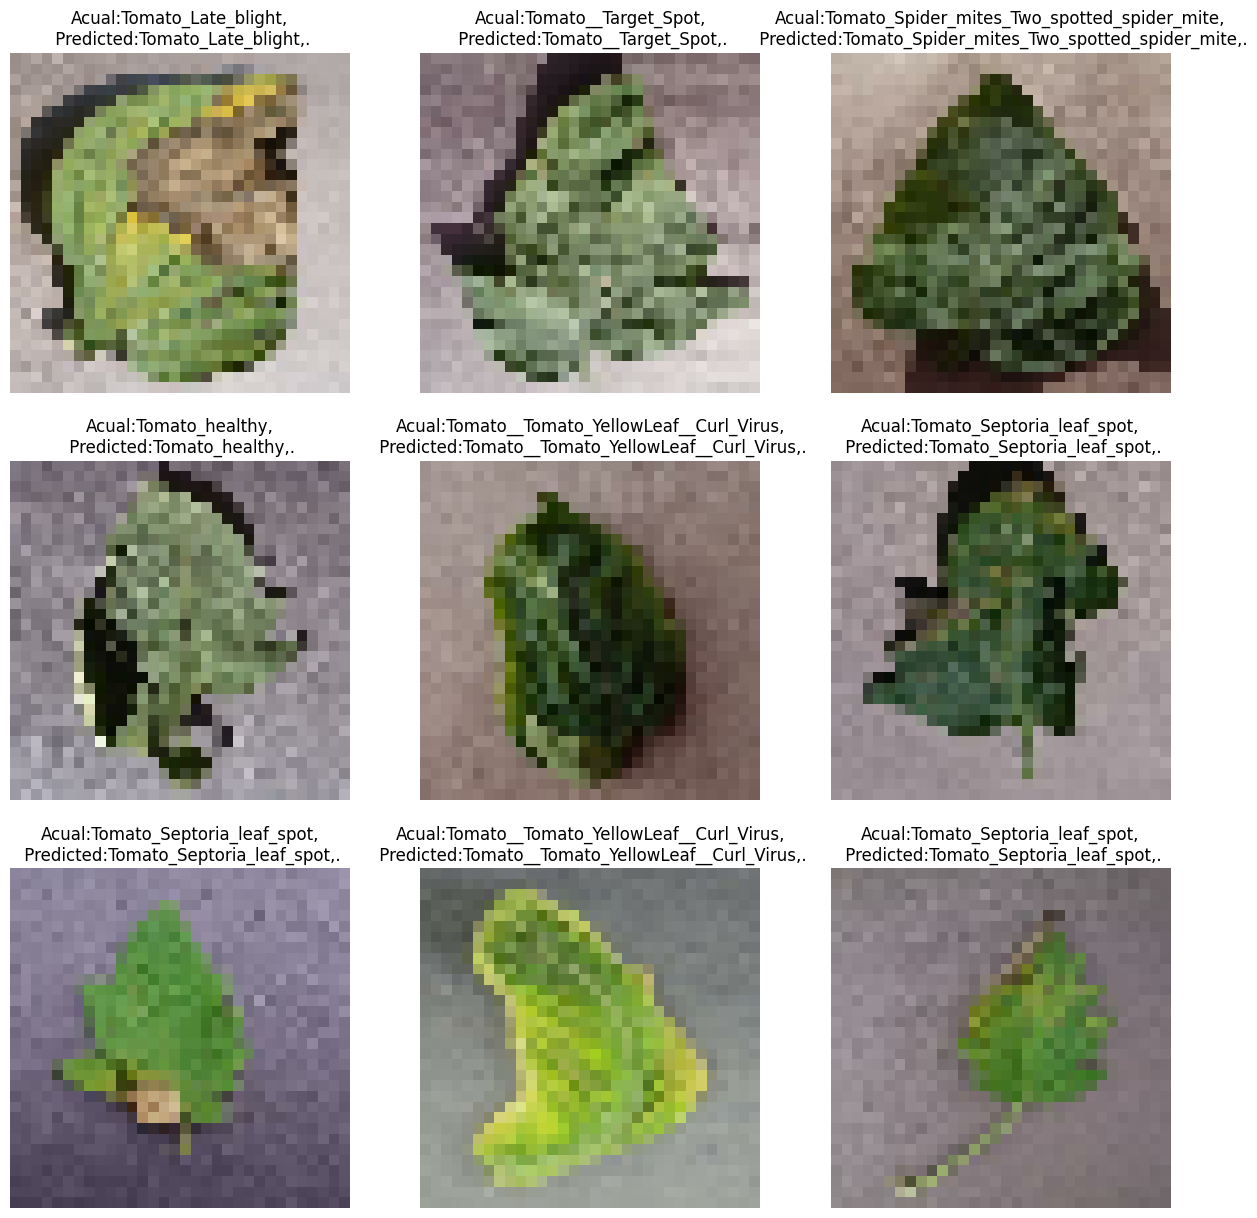

In [185]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Acual:{actual_class},\n Predicted:{predicted_class},.")
        plt.axis("off")

In [187]:
model_version=2
model.save(f"../models/2.h5")